---
title: "Comparing two different simulation strategies - Direct Model vs Genetics Model"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-12-14"
file-modified: "2023-12-14"
abstract: "We developed a simulation strategy using a random orthogonal matrix (direct model). FactorGo proposed a generative model from SNP effect size (Genetics model). Here we compare these two strategies."

---

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe_CV
from nnwmf.optimize import FrankWolfe

In [2]:
#| code-fold: false

ntrait = 3 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 100 # K

In [3]:
h2     = np.ones(ngwas) * 0.6
hg2    = np.ones(ngwas) * 0.2
hm2    = h2 - hg2

In [6]:
def get_sample_indices(nclass, n, shuffle = True):
    ''' 
    Distribute the samples in the categories (classes)
    '''
    rs = 0.6 * np.random.rand(nclass) + 0.2 # random sample from [0.2, 0.8)
    z = np.array(np.round((rs / np.sum(rs)) * n), dtype = int)
    z[-1] = n - np.sum(z[:-1])
    tidx = np.arange(n)
    if shuffle:
        np.random.shuffle(tidx)
    bins = np.zeros(nclass + 1, dtype = int)
    bins[1:] = np.cumsum(z)
    #sdict = {i : np.sort(tidx[bins[i]:bins[i+1]]) for i in range(nclass)}
    C = [np.sort(tidx[bins[i]:bins[i+1]]) for i in range(nclass)]
    return C

In [11]:
C = get_sample_indices(3, 20, shuffle = True)

In [17]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [15]:
[i for idx in range(20) for i in range(3) if idx in C[i]]

[1, 0, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1]

In [4]:
sample_dict = mpy_simulate.get_sample_indices(ntrait, ngwas, shuffle = False)
sample_indices = [x for _, x in sample_dict.items()]
unique_labels  = [k for k, _ in sample_dict.items()]
class_labels = [None for x in range(ngwas)]
for k, x in sample_dict.items():
    for i in x:
        class_labels[i] = k

In [5]:
from scipy import stats as spstats

def sample_covariance_matrix (covX, size):
    n, p = size
    L = np.linalg.cholesky(covX)
    Z = np.random.normal(0, 1, size = n * p).reshape(n, p)
    Zstd = mpy_simulate.do_standardize(Z, axis = 1)
    return L @ Zstd


rholist = [0.8 for _ in unique_labels]
ggT = np.sqrt(np.einsum('i,j->ij', hg2, hg2))
F = spstats.ortho_group.rvs(nsnp)[:, :nfctr]
covL = mpy_simulate.get_blockdiag_matrix(ngwas, rholist, sample_indices, bg = 0.1) * ggT
L = np.random.multivariate_normal(np.zeros(ngwas), covL, size = nfctr).T / np.sqrt(nfctr)
#L_ = sample_covariance_matrix(covL, (ngwas, nfctr))

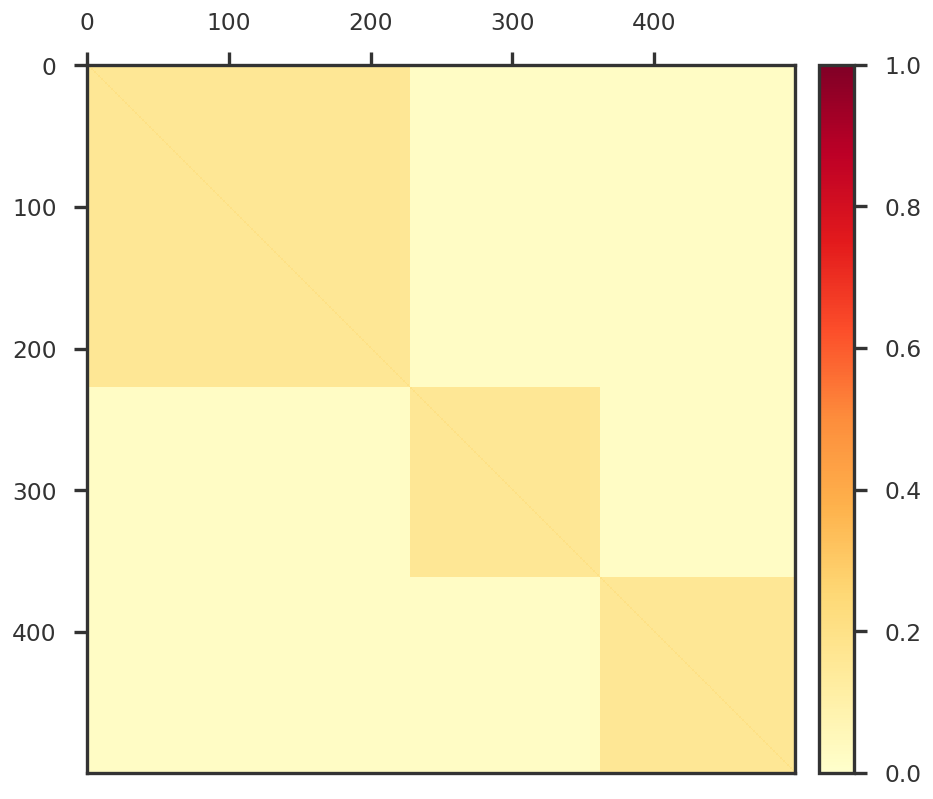

In [6]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
#mpy_plotfn.plot_covariance_heatmap(ax1, L * np.sqrt(nfctr))
mpy_plotfn.plot_heatmap(ax1, covL)

plt.tight_layout()
plt.show()

In [7]:
Y0 = L @ F.T
print ("Rows of Y0")
print (f"Median expectation: {np.median(np.mean(Y0, axis = 1)):g}")
print (f"Median variance (times P): {np.median(np.var(Y0, axis = 1) * nsnp):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(Y0), axis = 1)):g}")
print ()
print ("Columns of Y0")
print (f"Median expectation: {np.median(np.mean(Y0, axis = 0)):g}")
print (f"Median variance (times N): {np.median(np.var(Y0, axis = 0) * ngwas):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(Y0), axis = 0)):g}")
print (f"Median L1 norm: {np.median(np.sum(np.abs(Y0), axis = 0)):g}")
print ()

nrow = ngwas
ncol = nsnp
scaleM = np.sqrt(hm2 * 0.5 / ncol)
M = np.random.laplace(np.zeros(nrow), scaleM, size = (ncol, nrow)).T
# r_M = 1.
# for i in range(nsnp):
#     M[:, i] = M[:, i] * r_M / np.linalg.norm(M[:, i], ord = 1)
print ("Rows of M")
print (f"Median expectation: {np.median(np.mean(M, axis = 1)):g}")
print (f"Median variance (times P): {np.median(np.var(M, axis = 1) * ncol):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(M), axis = 1)):g}")
print ()
print ("Columns of M")
print (f"Median expectation: {np.median(np.mean(M, axis = 0)):g}")
print (f"Median variance (times N): {np.median(np.var(M, axis = 0) * nrow):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(M), axis = 0)):g}")
print (f"Median L1 norm: {np.median(np.sum(np.abs(M), axis = 0)):g}")
print ()

Y = Y0 + M
print ("Rows of Y")
print (f"Median expectation: {np.median(np.mean(Y, axis = 1)):g}")
print (f"Median variance (times P): {np.median(np.var(Y, axis = 1) * nsnp):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(Y), axis = 1)):g}")
print ()
print ("Columns of Y")
print (f"Median expectation: {np.median(np.mean(Y, axis = 0)):g}")
print (f"Median variance (times N): {np.median(np.var(Y, axis = 0) * ngwas):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(Y), axis = 0)):g}")
print (f"Median L1 norm: {np.median(np.sum(np.abs(Y), axis = 0)):g}")
print ()

Rows of Y0
Median expectation: -0.000155426
Median variance (times P): 0.224106
Median L2 norm squared: 0.224177

Columns of Y0
Median expectation: 0.000209719
Median variance (times N): 0.0512845
Median L2 norm squared: 0.0865713
Median L1 norm: 5.42823

Rows of M
Median expectation: -1.05241e-05
Median variance (times P): 0.396502
Median L2 norm squared: 0.396703

Columns of M
Median expectation: 6.99139e-05
Median variance (times N): 0.197444
Median L2 norm squared: 0.197776
Median L1 norm: 7.05178

Rows of Y
Median expectation: -0.000146142
Median variance (times P): 0.620688
Median L2 norm squared: 0.621036

Columns of Y
Median expectation: 0.000142319
Median variance (times N): 0.252043
Median L2 norm squared: 0.287131
Median L1 norm: 9.1555



In [8]:
covE = np.eye(nsnp) * 1 / 40000
noise = np.random.multivariate_normal(np.zeros(nsnp), covE, size = ngwas)
print ("Rows of noise")
print (f"Median expectation: {np.median(np.mean(noise, axis = 1)):g}")
print (f"Median variance (times P): {np.median(np.var(noise, axis = 1) * nsnp):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(noise), axis = 1)):g}")
print ()
print ("Columns of noise")
print (f"Median expectation: {np.median(np.mean(noise, axis = 0)):g}")
print (f"Median variance: {np.median(np.var(noise, axis = 0)):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(noise), axis = 0)):g}")
print (f"Median L1 norm: {np.median(np.sum(np.abs(noise), axis = 0)):g}")
print ()

Rows of noise
Median expectation: -1.09343e-05
Median variance (times P): 0.0249726
Median L2 norm squared: 0.0249982

Columns of noise
Median expectation: -1.26038e-05
Median variance: 2.49111e-05
Median L2 norm squared: 0.012479
Median L1 norm: 1.99437



In [9]:
Y * np.sqrt(nsnp / h2.reshape(ngwas, 1))

array([[-1.33357538, -0.95947936,  0.17148265, ..., -0.4863197 ,
        -0.71514046, -0.15900849],
       [-0.04274935, -0.6466637 ,  0.469406  , ...,  0.64127725,
        -0.30498921,  0.20851449],
       [-1.69318498, -0.23030792,  0.4263881 , ...,  0.00532535,
        -1.32942984, -1.62658069],
       ...,
       [ 0.85148603, -0.79558655, -0.48725268, ..., -1.88284527,
         0.47964622, -1.33434093],
       [ 0.68072411, -0.18798221, -0.12279653, ..., -0.76358145,
         0.1272466 , -1.33720936],
       [-0.01052967,  0.16498775,  1.41944669, ..., -0.10789497,
        -0.16660526, -2.33952439]])

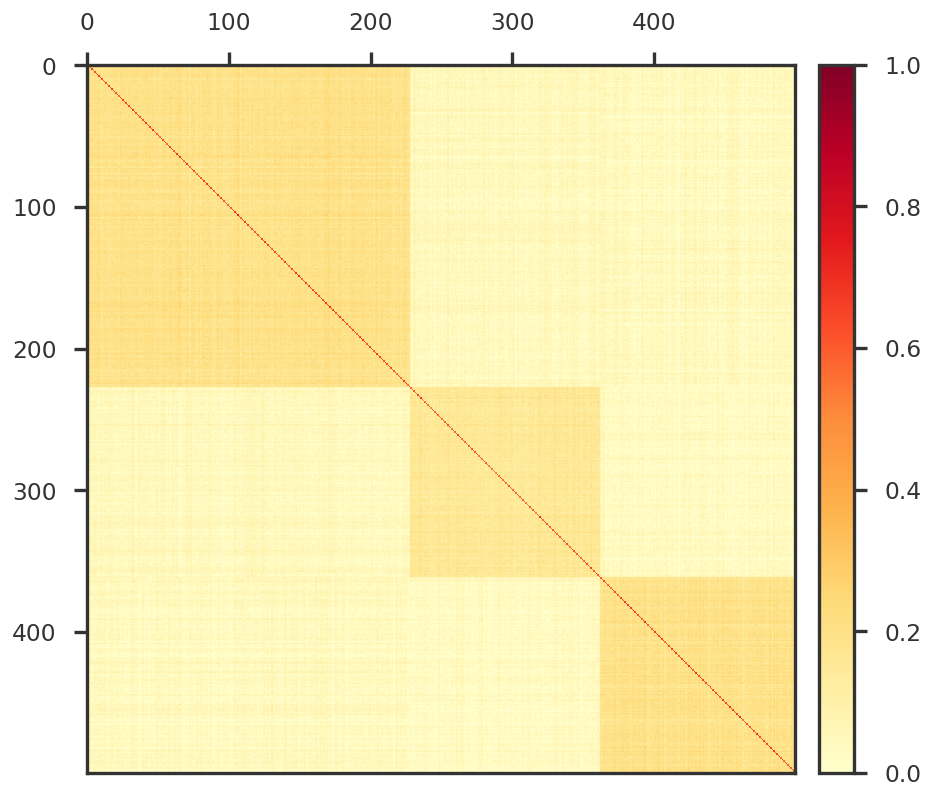

In [10]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
# diag(cov(Y)) = h2 / P. [see for e.g. eq.58]
# scale Y with P / h2 so that the diagonal elements are 1.
mpy_plotfn.plot_covariance_heatmap(ax1, Y * np.sqrt(nsnp))
#mpy_plotfn.plot_heatmap(ax1, np.cov(Y) / h2)

plt.tight_layout()
plt.show()

In [11]:
print ("Rows of F")
print (f"Median expectation: {np.median(np.mean(F, axis = 1)):g}")
print (f"Median variance (times K): {np.median(np.var(F, axis = 1) * nfctr):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(F), axis = 1)):g}")
print ()
print ("Columns of F")
print (f"Median expectation: {np.median(np.mean(F, axis = 0)):g}")
print (f"Median variance (times P): {np.median(np.var(F, axis = 0) * nsnp):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(F), axis = 0)):g}")

Rows of F
Median expectation: -1.93028e-06
Median variance (times K): 0.0990139
Median L2 norm squared: 0.0999616

Columns of F
Median expectation: -5.1289e-05
Median variance (times P): 0.999559
Median L2 norm squared: 1


In [12]:
print ("Rows of L")
print (f"Median expectation: {np.median(np.mean(L, axis = 1)):g}")
print (f"Median variance (times K): {np.median(np.var(L, axis = 1) * nfctr):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(L), axis = 1)):g}")
print ()
print ("Columns of L")
print (f"Median expectation: {np.median(np.mean(L, axis = 0)):g}")
print (f"Median variance (times N): {np.median(np.var(L, axis = 0) * ngwas):g}")
print (f"Median L2 norm squared: {np.median(np.sum(np.square(L), axis = 0)):g}")

Rows of L
Median expectation: -9.67536e-05
Median variance (times K): 0.223455
Median L2 norm squared: 0.224177

Columns of L
Median expectation: -0.00185697
Median variance (times N): 0.526052
Median L2 norm squared: 0.825194


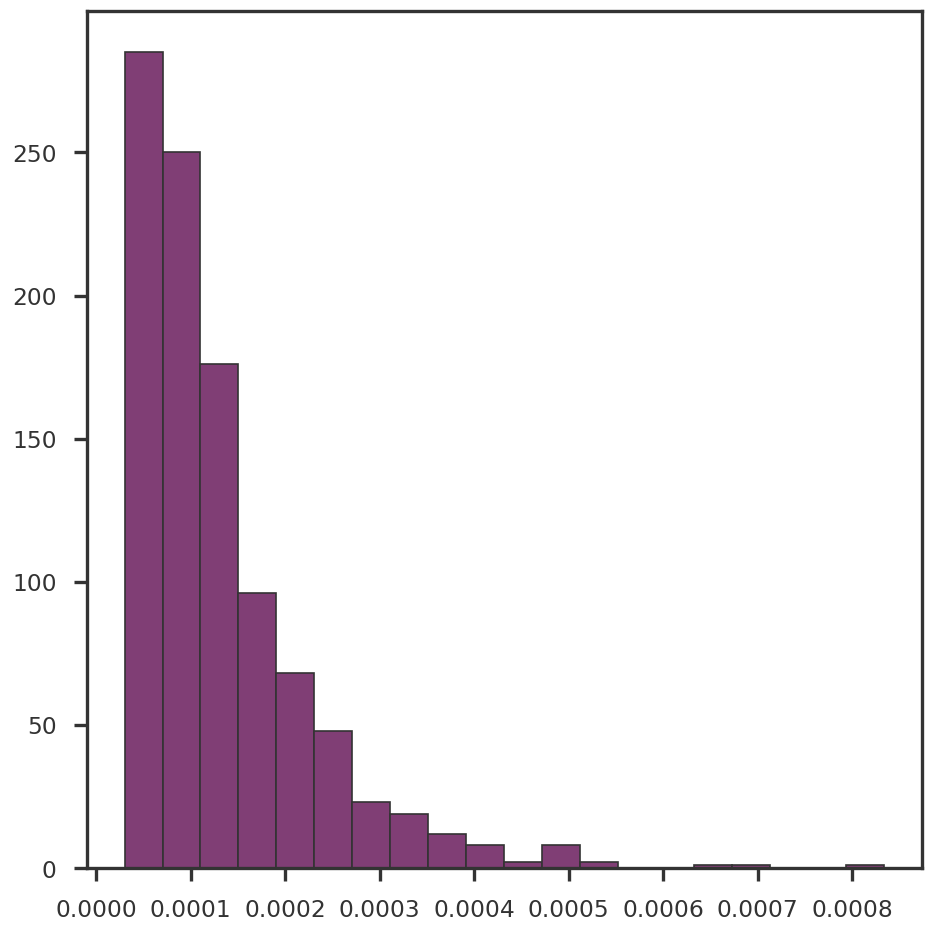

In [13]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

ax1.hist(np.var(Y0, axis = 0))

plt.tight_layout()
plt.show()

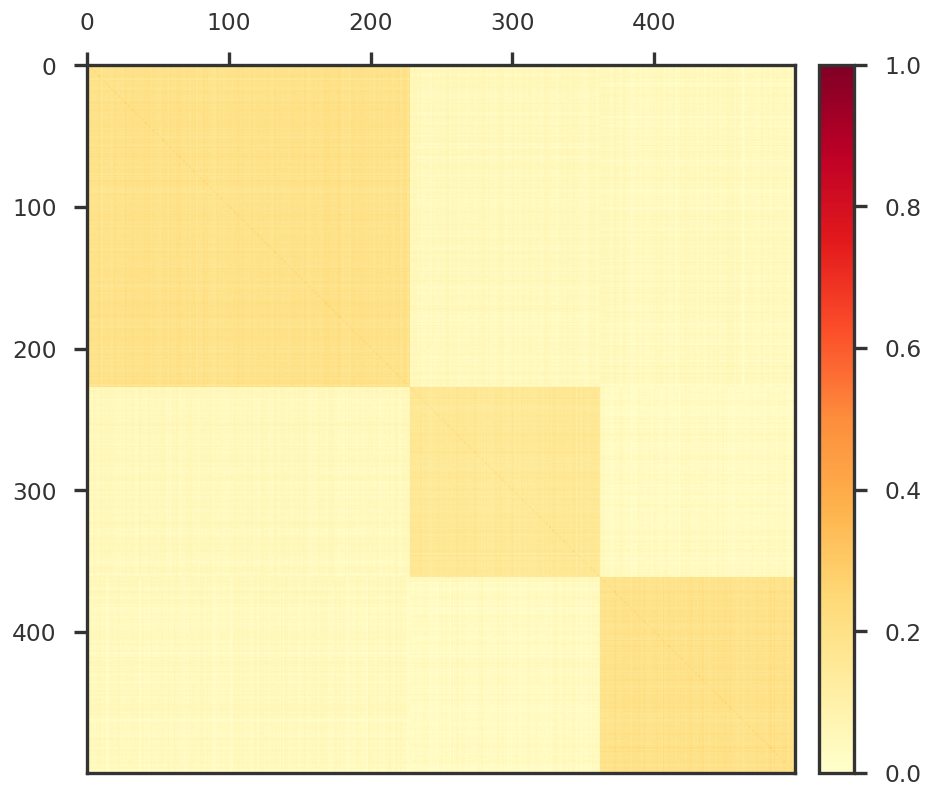

In [14]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
mpy_plotfn.plot_covariance_heatmap(ax1, Y0 * np.sqrt(nsnp))
#mpy_plotfn.plot_heatmap(ax1, covL)

plt.tight_layout()
plt.show()

In [15]:
np.linalg.norm(Y0, ord = 1)

16.89425850071007

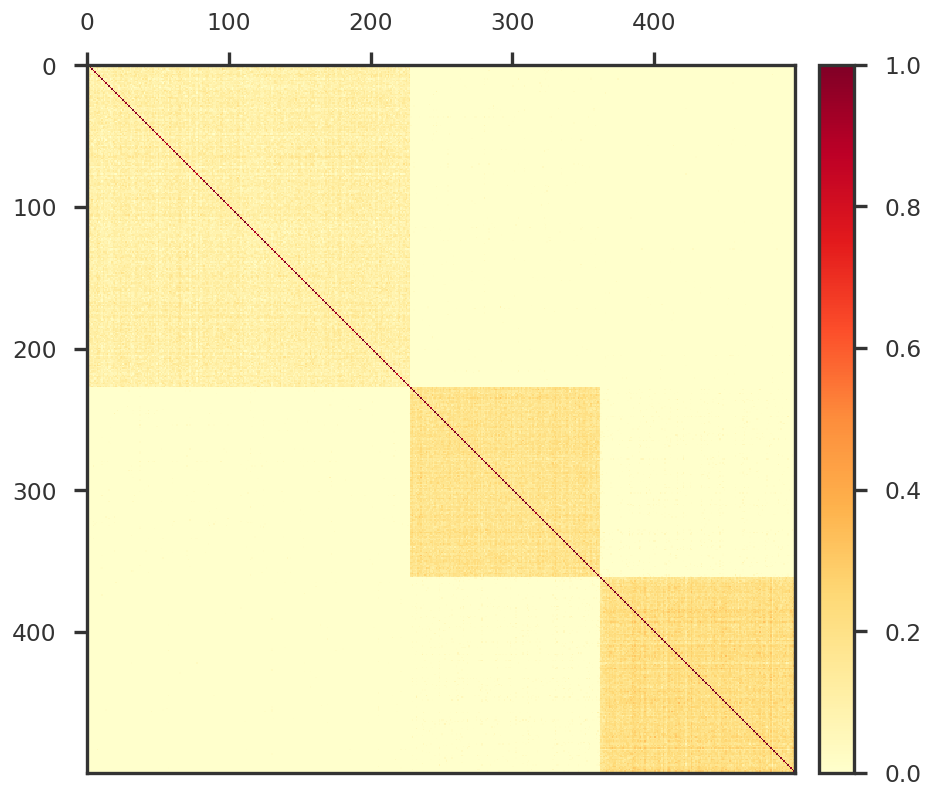

In [16]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
mpy_plotfn.plot_covariance_heatmap(ax1, mpy_simulate.do_standardize(Y))
#mpy_plotfn.plot_heatmap(ax1, covL)

plt.tight_layout()
plt.show()

In [59]:
hg2 = 0.9
maf = np.random.uniform(0.05, 0.5, nsnp)
var_Lb = hg2 / (nsnp * nfctr * 2.0 * maf * (1 - maf))

In [60]:
Lb = np.zeros((nsnp,nfctr))
for k in range(nfctr):
    Lb[:,k] = np.random.normal(0, np.sqrt(var_Lb))
Fb = np.random.normal(0, 1, ngwas * nfctr).reshape(ngwas,nfctr)

In [61]:
betab = np.zeros((ngwas, nsnp))
for i in range(ngwas):
    betab[i,:] = np.dot(Lb, Fb[i, :])

In [62]:
var_Xbetab = np.square(betab * 2.0 * maf * (1 - maf))
var_Yb = np.sum(var_Xbetab, axis = 1) / hg2
residuals_b = var_Yb.reshape(-1, 1) - var_Xbetab

In [63]:
nsample = 10000

stderr2_b = residuals_b / (nsample * (2.0 * maf * (1 - maf) + np.square(2.0 * maf)))
Z_true = betab / np.sqrt(stderr2_b)
Z_true_cent = mpy_simulate.do_standardize(Z_true, scale = False)

In [64]:
Z = np.zeros_like(Z_true)
for i in range(ngwas):
    Sigma_est = np.zeros((nsnp, nsnp))
    Sigma_est[np.diag_indices(nsnp)] = stderr2_b[i,:]
    beta_est = np.random.multivariate_normal(betab[i,:], Sigma_est)
    Z[i, :] = beta_est / np.sqrt(stderr2_b[i, :])
Z_cent = mpy_simulate.do_standardize(Z, scale = False)

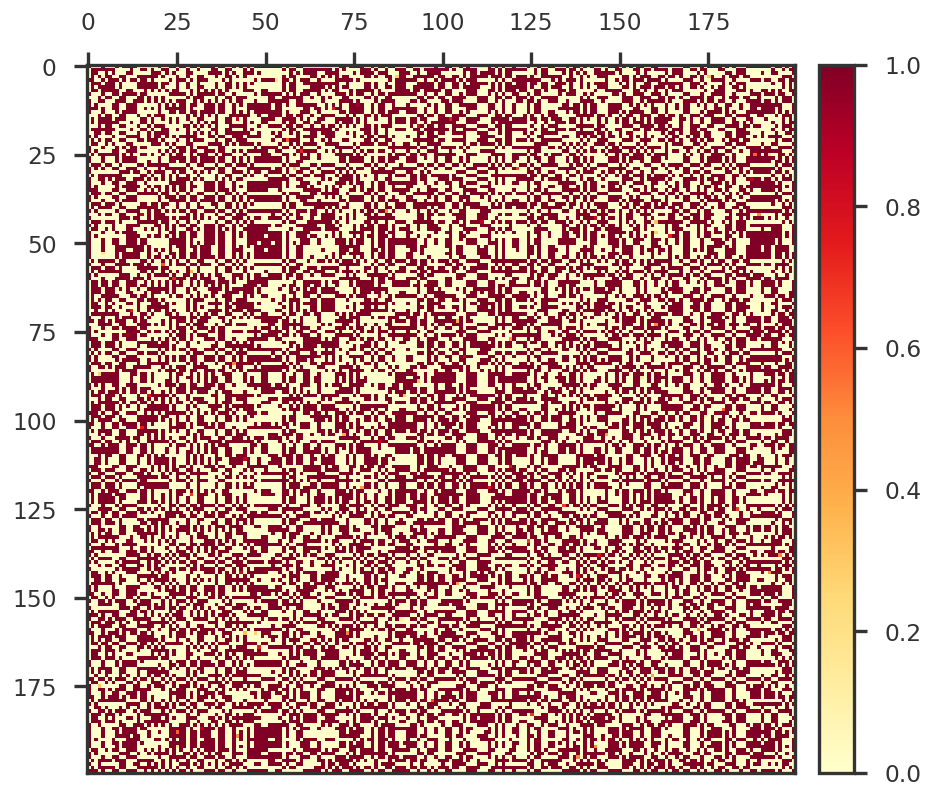

In [65]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, Z_cent)

plt.tight_layout()
plt.show()

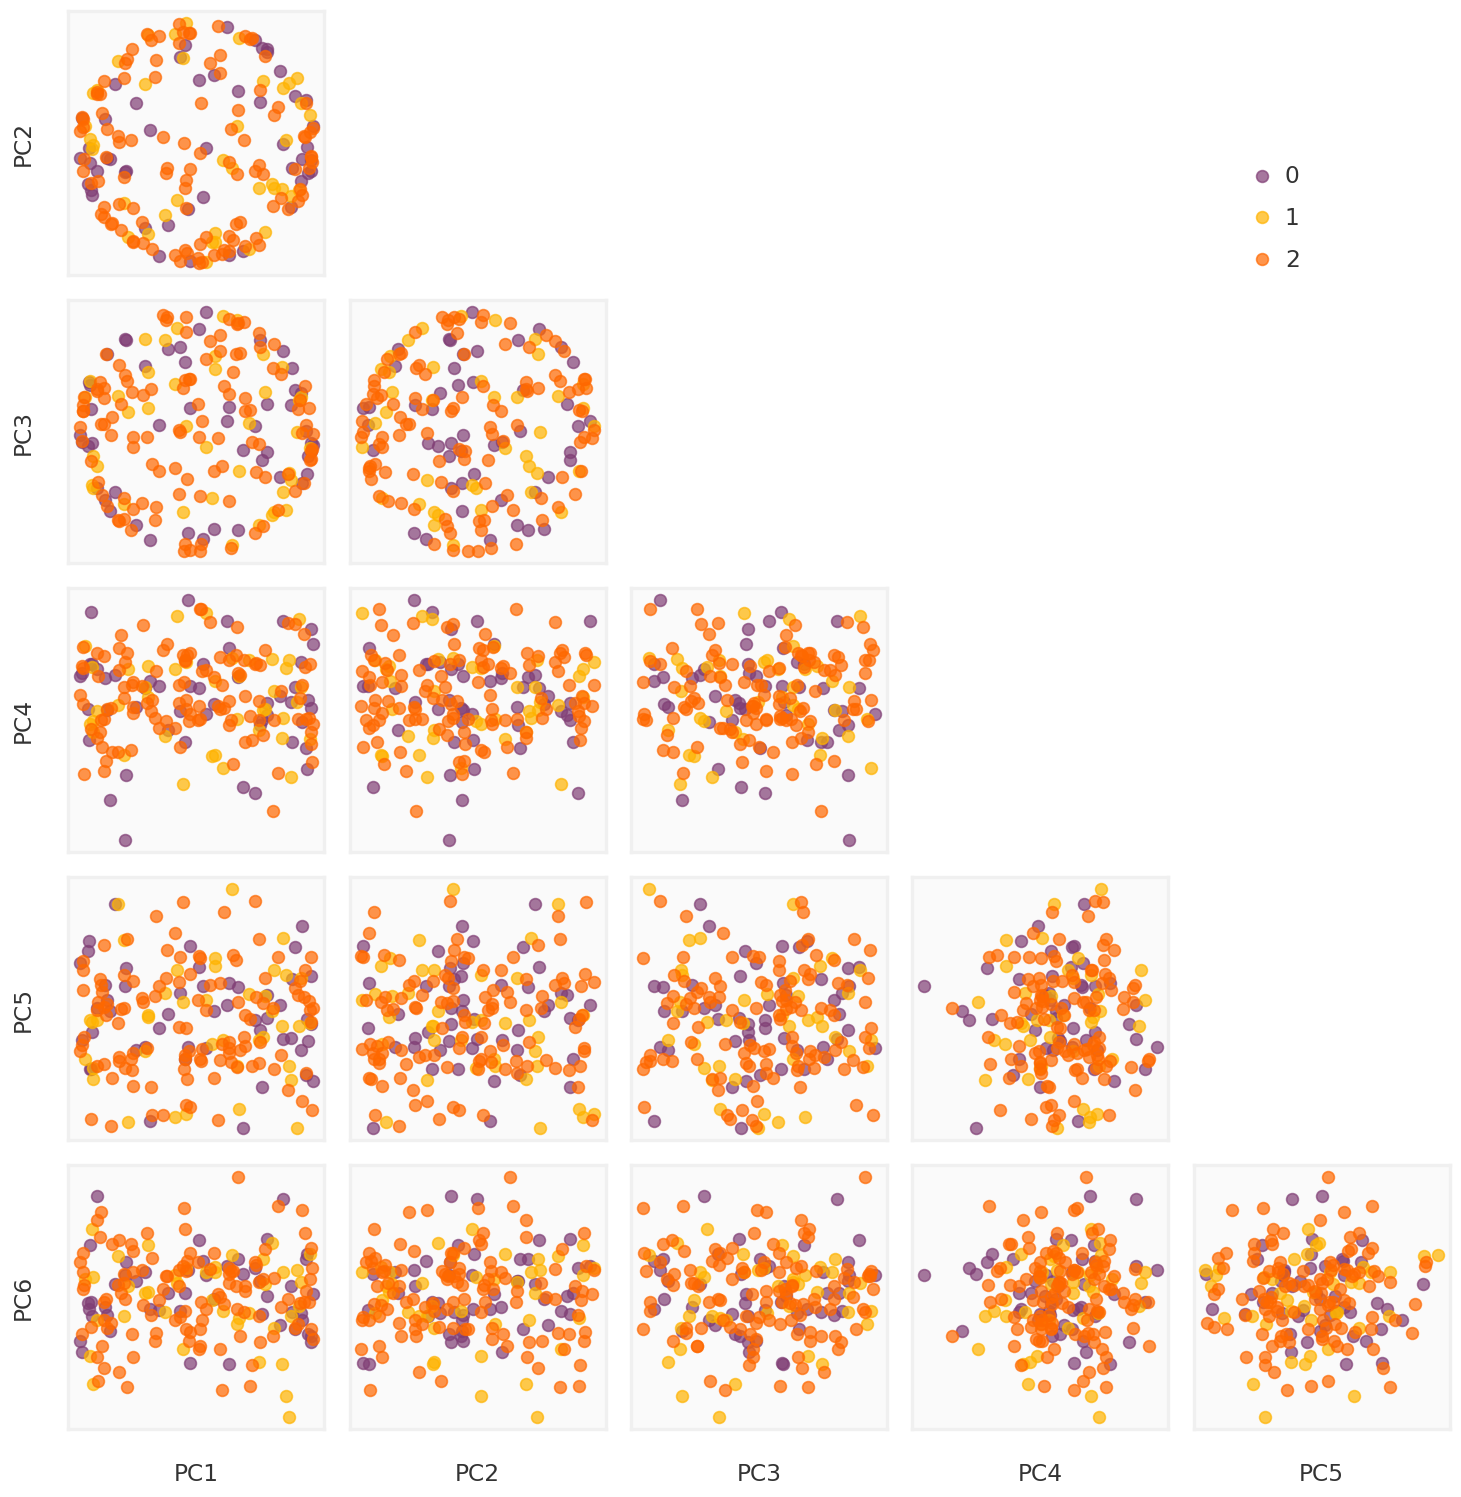

In [66]:
def truncated_SVD(X, thres = 0.9):
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    k = np.where(np.cumsum(S / np.sum(S)) >= thres)[0][0]
    pcomps = U[:, :k] @ np.diag(S[:k])
    return U, S, Vt, pcomps

_, S_tsvd, _, pcomps_tsvd = truncated_SVD(Z_cent)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_tsvd, class_labels, unique_labels)
plt.show()

In [17]:
rpca = IALM()
rpca.fit(Y)
np.linalg.matrix_rank(rpca.L_)

290

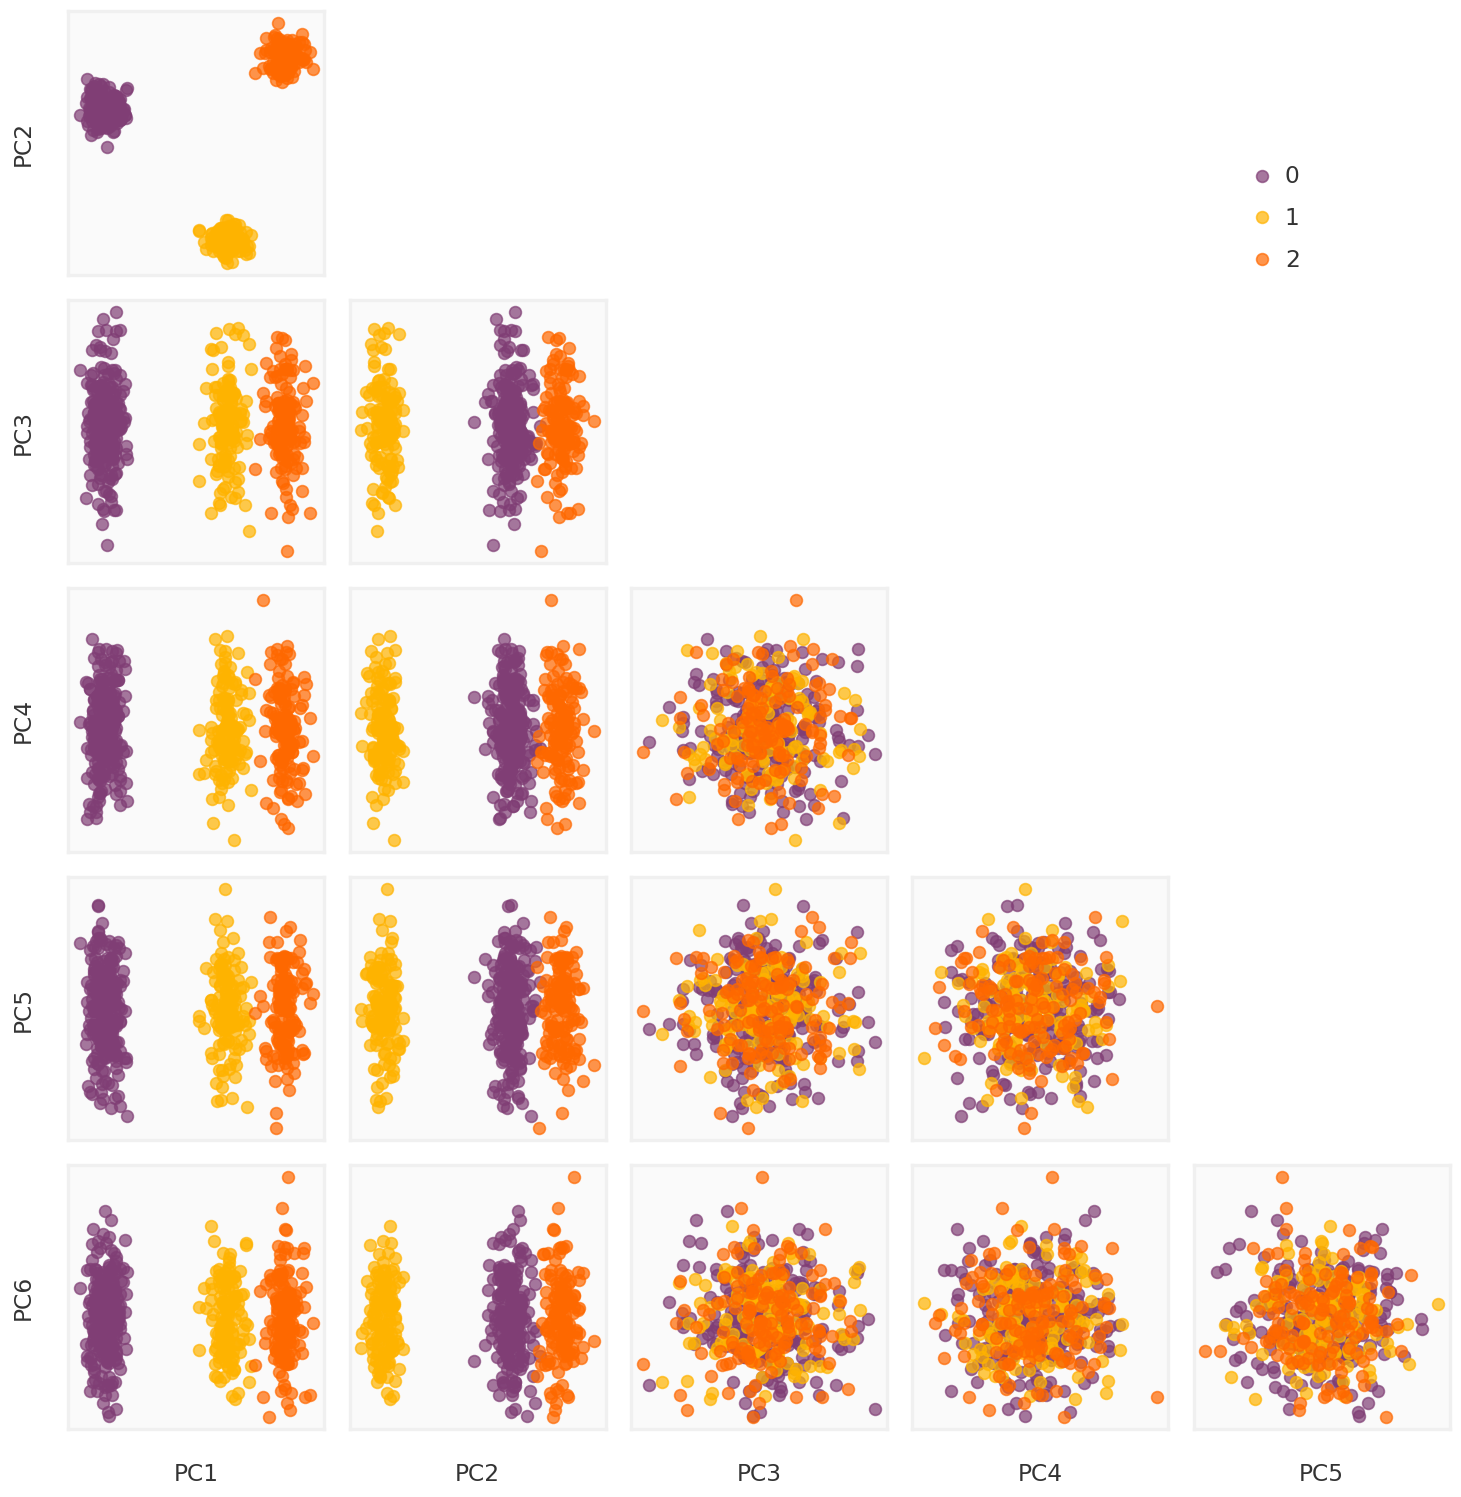

In [18]:
Y_rpca_cent = mpy_simulate.do_standardize(rpca.L_, scale = False)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Y_rpca_cent, full_matrices = False)
pcomps_rpca = U_rpca @ np.diag(S_rpca)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()

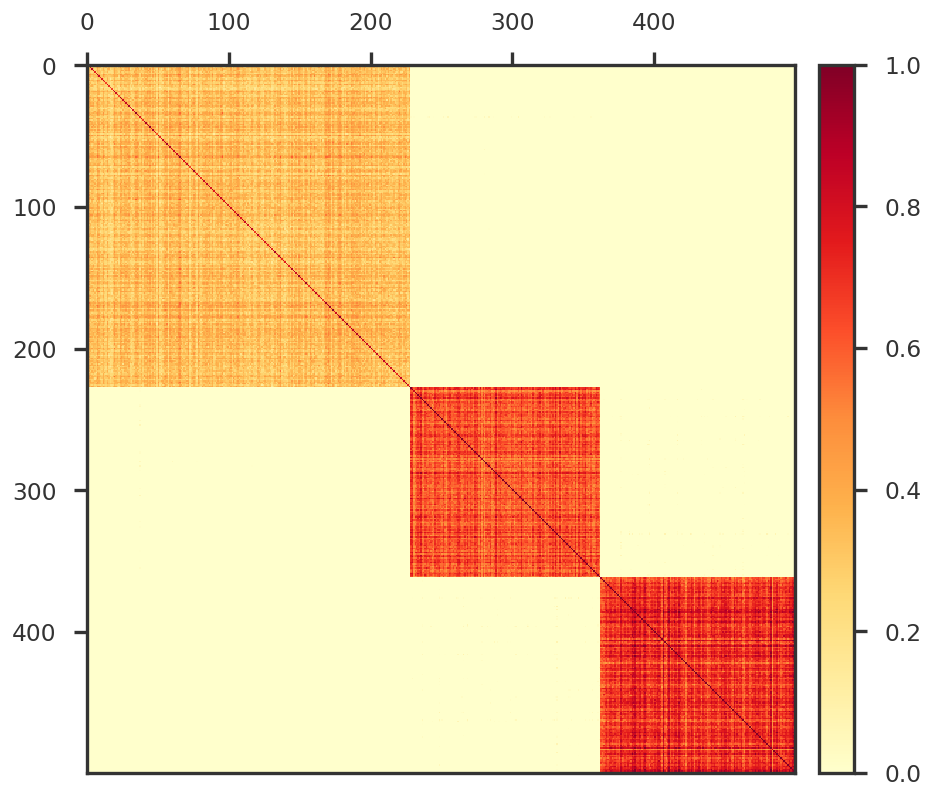

In [19]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
mpy_plotfn.plot_covariance_heatmap(ax1, mpy_simulate.do_standardize(Y_rpca_cent))
#mpy_plotfn.plot_heatmap(ax1, covL)

plt.tight_layout()
plt.show()

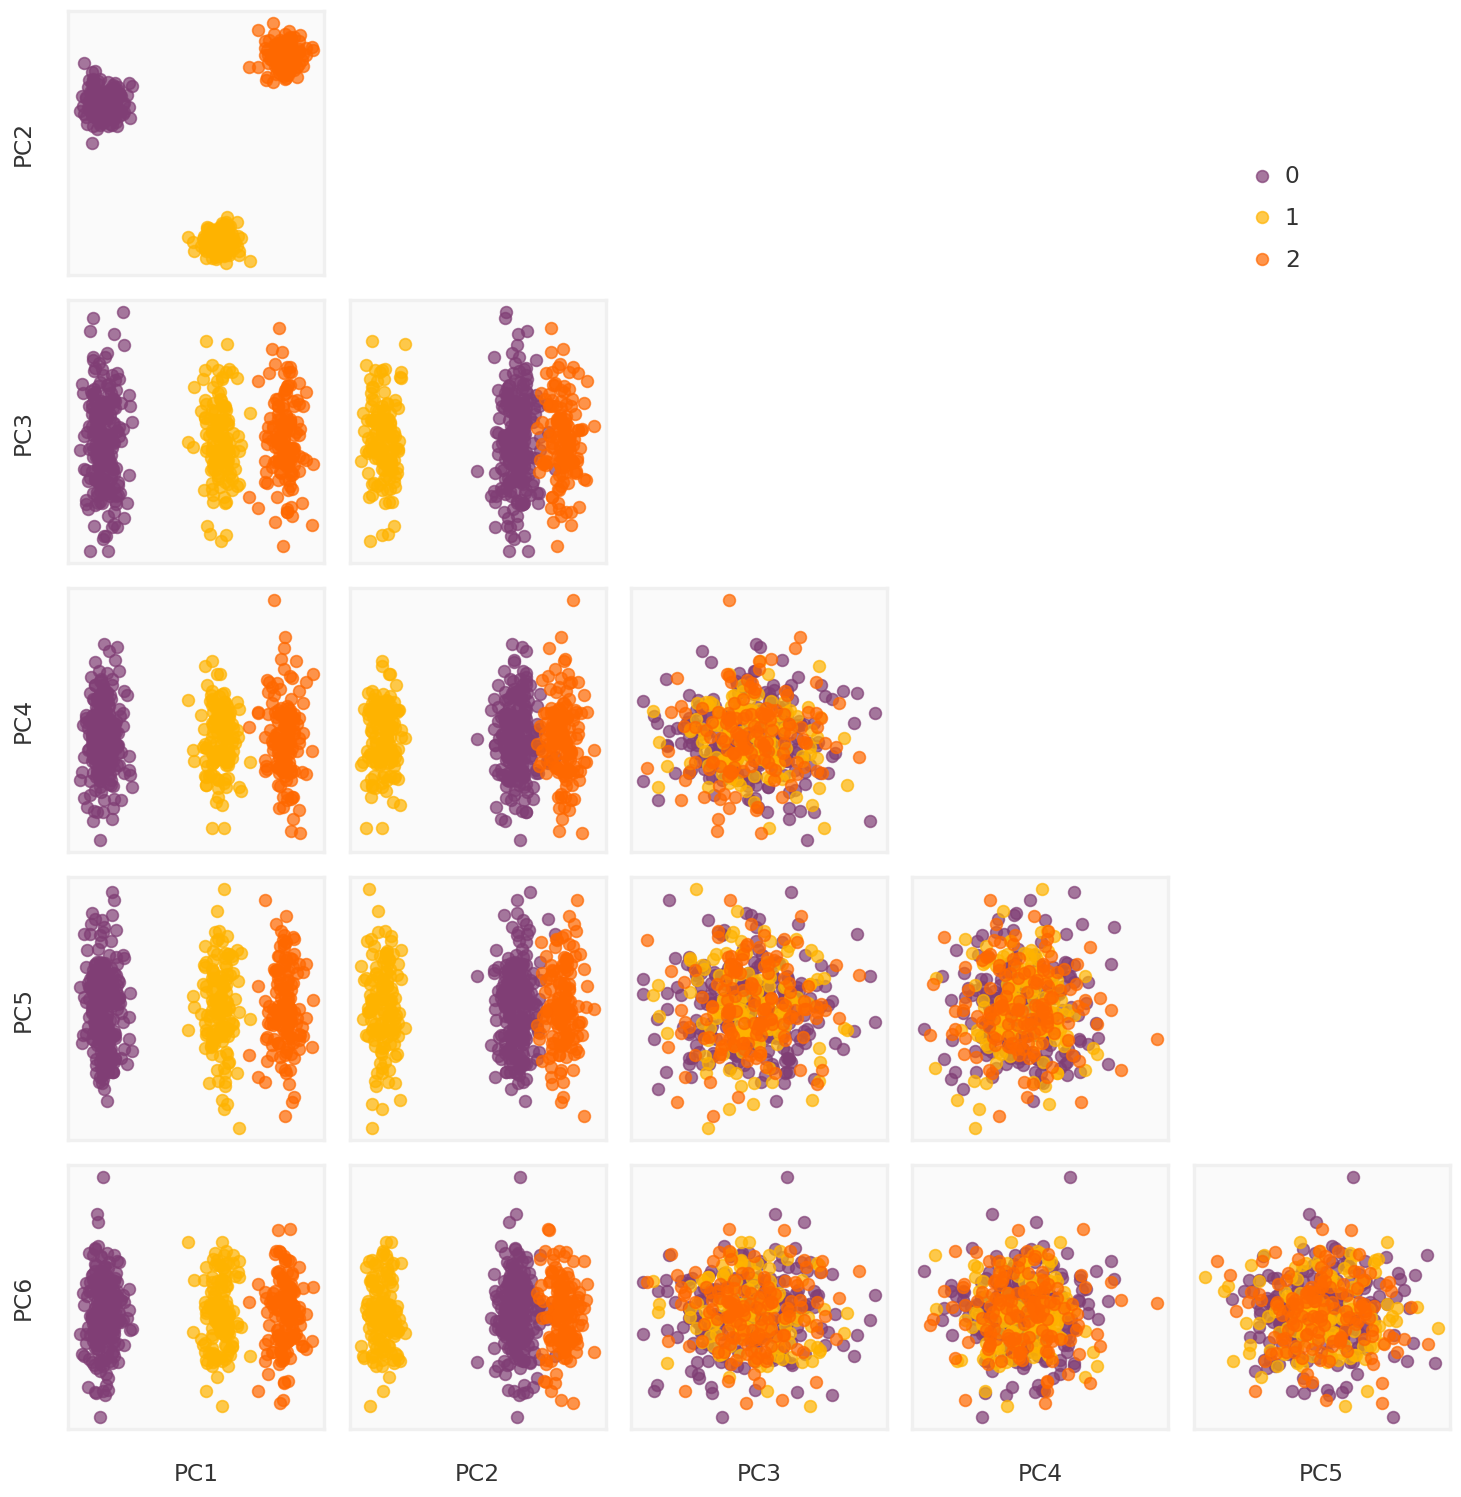

In [20]:
def truncated_SVD(X, thres = 0.9):
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    k = np.where(np.cumsum(S / np.sum(S)) >= thres)[0][0]
    pcomps = U[:, :k] @ np.diag(S[:k])
    return U, S, Vt, pcomps

_, S_tsvd, _, pcomps_tsvd = truncated_SVD(mpy_simulate.do_standardize(Y))
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_tsvd, class_labels, unique_labels)
plt.show()

In [22]:
nnm_sparse = FrankWolfe(model = 'nnm-sparse', max_iter = 1000, svd_max_iter = 50, 
                        tol = 1e-3, step_tol = 1e-5, simplex_method = 'sort',
                        show_progress = True, debug = True, print_skip = 100)
#nnm_sparse.fit(np.nanmean(X_nan, axis = 0, keepdims = True), (300.0, 0.5))
nnm_sparse.fit(mpy_simulate.do_standardize(Y, axis=0), (300.0, 0.5))

2024-01-11 11:00:37,502 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 2.10098e+06
2024-01-11 11:00:49,306 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.001. Duality Gap 45.1048
2024-01-11 11:01:00,465 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 200. Step size 0.000. Duality Gap 22.8586
2024-01-11 11:01:11,607 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 300. Step size 0.001. Duality Gap 30.7189
2024-01-11 11:01:22,735 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 400. Step size 0.001. Duality Gap 29.6669
2024-01-11 11:01:33,922 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 500. Step size 0.000. Duality Gap 13.3876
2024-01-11 11:01:45,169 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 600. Step size 0.000. Duality Gap 19.7748
2024-01-11 11:01:57,191 | nnwmf.optimize.frankwolfe                | INFO    | It

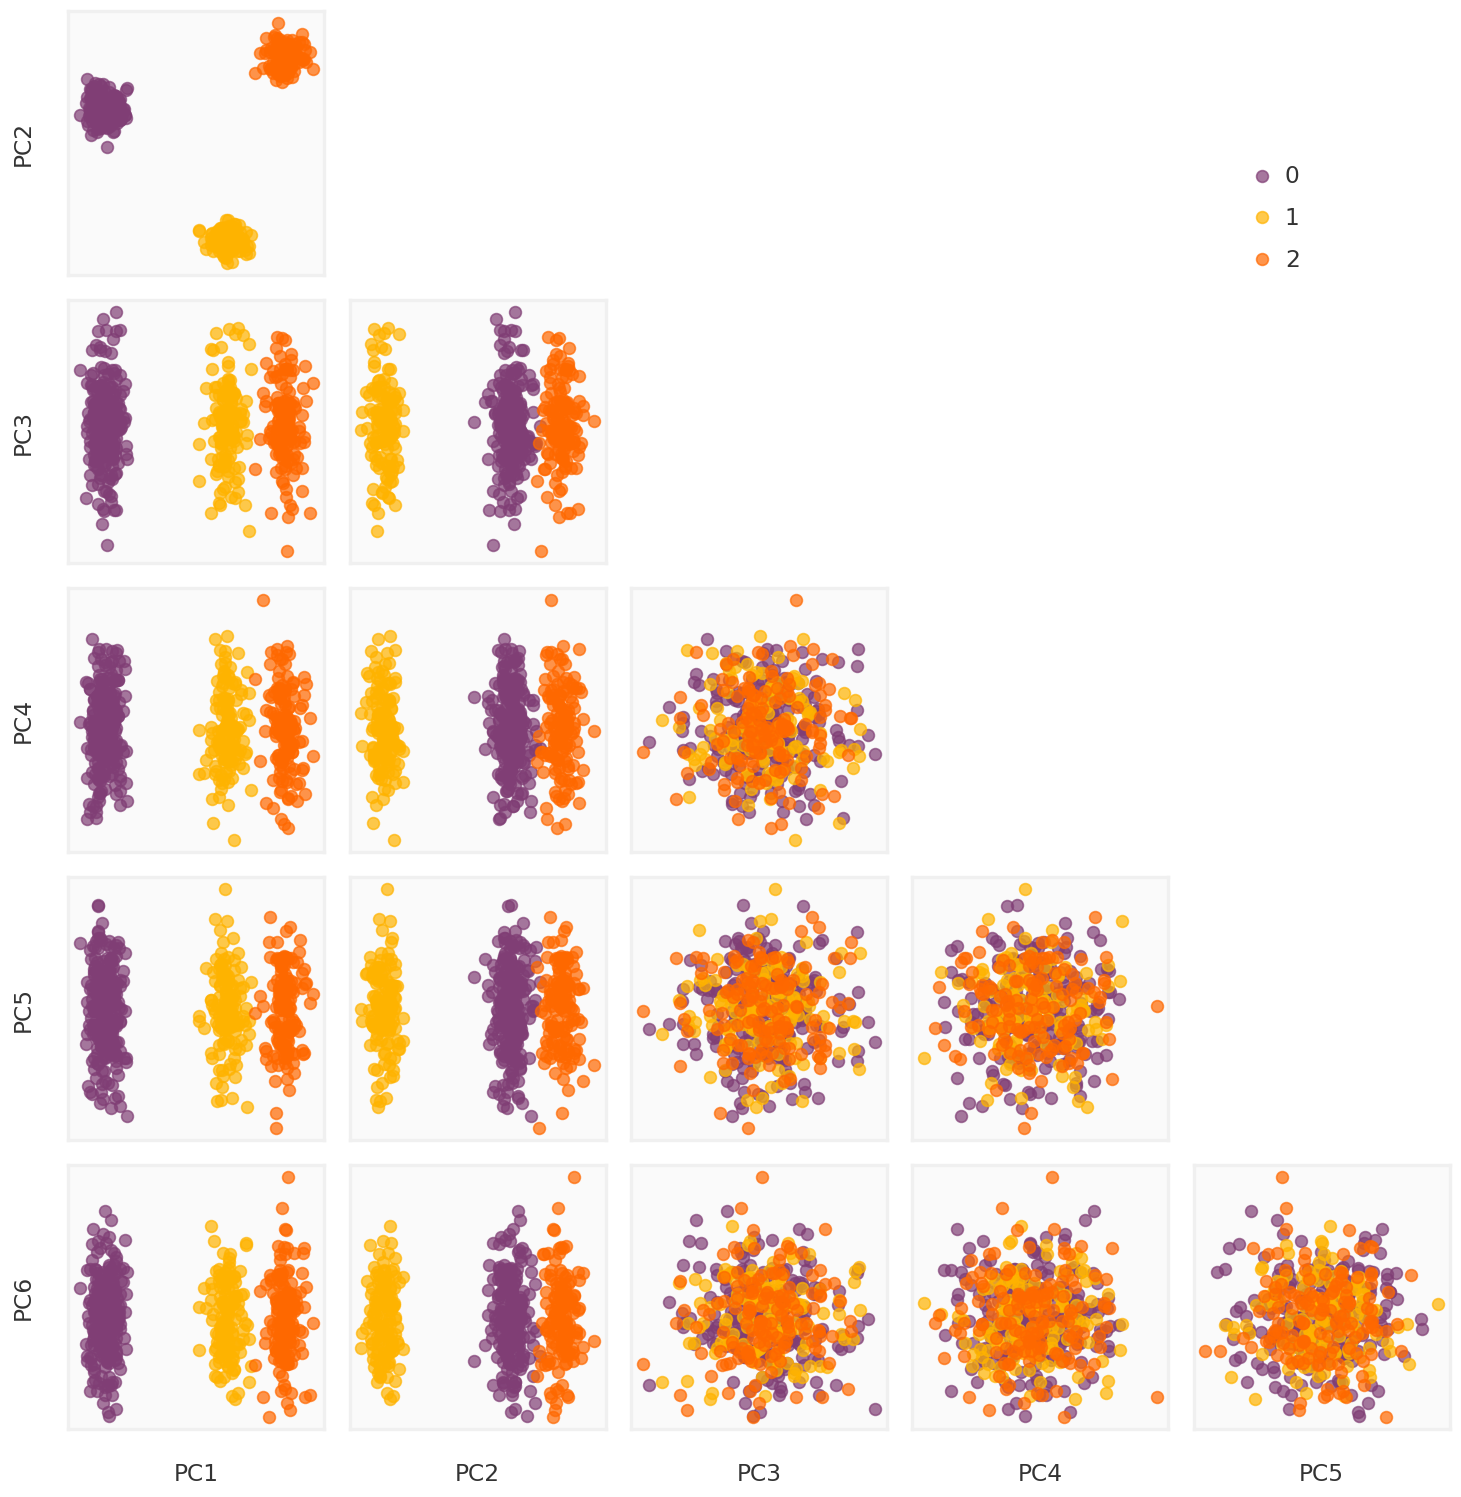

In [24]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_nnm_sparse, pcomps_nnm_sparse = get_principal_components(nnm_sparse.X)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()